In [ ]:
# Inférence & eval

In [351]:
from models.unet import UNet
import torch
import numpy as np
import matplotlib.pyplot as plt

thresholds   = [0.1, 1, 2.5]  # series of thresholds (unit: mm/h)
thresholds   = [100*k/12 for k in thresholds]

In [352]:
scores = torch.load('lastrun/scores.pt')

In [353]:
def plot_scores( scores, save=None):
    plt.plot(scores['train_losses'], label='loss train')
    plt.plot(scores['val_losses'], label='loss val')
    plt.legend()
    plt.show()
    sc = scores['val_f1_pred']
    l = len(sc)
    ar = np.array([list(s) for s in sc])
    plt.plot(ar[:,0], label='F1 class 1')
    plt.plot([scores['f1_pers'][0]]*l,'b')
    plt.plot(ar[:,1], label='F1 class 2')
    plt.plot([scores['f1_pers'][1]]*l,'r')
    plt.plot(ar[:,2], label='F1 class 3')
    plt.plot([scores['f1_pers'][2]]*l,'g')
    plt.legend()
    if save:
        plt.savefig(save)
    else:
        plt.show()


In [399]:
# get train, val and test datasets
from loader.meteonet import MeteonetDataset
from glob import glob
from tqdm import tqdm
from loader.utilities import split_date
from datetime import datetime

train_files = glob(f'data/rainmaps/y201[67]-*')
val_test_files = glob(f'data/rainmaps/y2018-*')

# split in validation/test sets according to Section 4.1 from [1]
test_files = []
val_files = []

for f in sorted(val_test_files, key=lambda f:split_date(f)):
    year, month, day, hour, _ = split_date(f)
    yday = datetime(year, month, day).timetuple().tm_yday - 1
    if (yday // 7) % 2 == 0: # odd week
        val_files.append(f)
    else:
        if not (yday % 7 == 0 and hour == 0): # ignore the first hour of the first day of even weeks
            test_files.append(f)

# datasets only rainmaps
train_ds = MeteonetDataset( train_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/train-wind.npz', tqdm=tqdm)
val_ds   = MeteonetDataset( val_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/val-wind.npz', tqdm=tqdm)
test_ds  = MeteonetDataset( test_files, 12, 18, 12, wind_dir='data/windmaps', cached=f'data/test-wind.npz', tqdm=tqdm)

# dataset rainmaps and windmaps
rain_val_ds = MeteonetDataset( val_files, 12, 18, 12, cached=f'data/val.npz', tqdm=tqdm)
rain_test_ds = MeteonetDataset( test_files, 12, 18, 12, cached=f'data/test.npz', tqdm=tqdm)

# important !
val_ds.norm_factor = train_ds.norm_factor
test_ds.norm_factor = train_ds.norm_factor
rain_val_ds.norm_factor = train_ds.norm_factor
rain_test_ds.norm_factor = train_ds.norm_factor

val_ds.params['U_moments'] = train_ds.params['U_moments']
val_ds.params['V_moments'] = train_ds.params['V_moments']

test_ds.params['U_moments'] = train_ds.params['U_moments']
test_ds.params['V_moments'] = train_ds.params['V_moments']


In [373]:
import matplotlib.pyplot as plt
from matplotlib import colors
from os.path import basename, dirname

def get_item_by_date(ds, date):
    """ utility: returns the item in which date belongs to """
    files = ds.params['files']
    items = ds.params['items']
        
    y,M,d,h,m = date
    f = f'{dirname(files[0])}/y{y}-M{M}-d{d}-h{h}-m{m}.npz'
    if not f in files:
        print('date not available')
        return None
    idx, _ = np.where(items[:-1]==files.index(f))
    return idx[0]

def plot_meteonet_rainmaps( ds, date, lon, lat, zone, title=None, save=None):
    """ plot rainfaill inputs of an element chosen by date from a Meteonoet dataset"""
    # inspired from https://github.com/meteofrance/meteonet/blob/master/notebooks/radar/open_rainfall.ipynb

    input_len = ds.params['input_len']
    files = ds.params['files']
    items = ds.params['items']
    idx = get_item_by_date(ds, date)
    
    if idx == None: return None
    
    fig, ax = plt.subplots(input_len//2, 2,figsize=(10,20))
    if title: fig.suptitle(title, fontsize=16)

    # Choose the colormap
    cmap = colors.ListedColormap(['silver','white', 'darkslateblue', 'mediumblue','dodgerblue', 
                                  'skyblue','olive','mediumseagreen','cyan','lime','yellow',
                                  'khaki','burlywood','orange','brown','pink','red','plum'])
    bounds = [-1,0,2,4,6,8,10,15,20,25,30,35,40,45,50,55,60,65,75]
    norm = colors.BoundaryNorm(bounds, cmap.N)


    for i in range(input_len//2):
        file = files[items[idx][2*i]]
        data = load_map(file)
        ax[i,0].pcolormesh(lon, lat, data, cmap=cmap, norm=norm)
        ax[i,0].set_ylabel('latitude (degrees_north)')
        y,M,d,h,m = split_date( basename(file))
        ax[i,0].set_title( f'{y}/{M}/{d} {h}:{m} - {zone} zone')
        
        file = files[items[idx][2*i+1]]
        data = load_map(file)
        pl = ax[i,1].pcolormesh(lon, lat, data, cmap=cmap, norm=norm)
        y,M,d,h,m = split_date( basename(file))
        ax[i,1].set_title( f'{y}/{M}/{d} {h}:{m} - {zone} zone')
        
    ax[input_len//2-1,0].set_xlabel('longitude (degrees_east)')
    ax[input_len//2-1,1].set_xlabel('longitude (degrees_east)')

    # Plot the color bar
    cbar = fig.colorbar(pl,ax=ax.ravel().tolist(),cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, 
                    orientation= 'vertical').set_label('Rainfall (in 1/100 mm) / -1 : missing values')
    plt.show()

def plot_inference(ds, date, model, lon, lat, zone, title):
    """ """
    item = ds[get_item_by_date(ds, date)]
    with torch.no_grad():
        y = model(item['inputs'].unsqueeze(0))

    # to do: compute target date

    pred = 1*(torch.sigmoid(y[0,0])>.5) + (torch.sigmoid(y[0,1])>.5) + (torch.sigmoid(y[0,2])>.5)    
    gt = 1*(item['target']>thresholds[0]) + (item['target']>thresholds[1]) + (item['target']>thresholds[2])
    
    cmap = colors.ListedColormap(['white', 'mediumblue','skyblue','cyan'])

    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle(title) 
    
    ax[0].set_title('prediction')
    ax[0].set_ylabel('latitude')
    ax[0].set_xlabel('longitude')
    ax[1].set_xlabel('longitude')
    
    fig.text(0.3,-0.05,'thresholds: mediumblue >= 0.8, skyblue >= 8.3, cyan >=20.3', )
    
    ax[0].pcolormesh(lon, lat, pred, cmap=cmap) 
    ax[1].set_title('ground truth')
    ax[1].pcolormesh(lon, lat, gt, cmap=cmap) 

    plt.show()


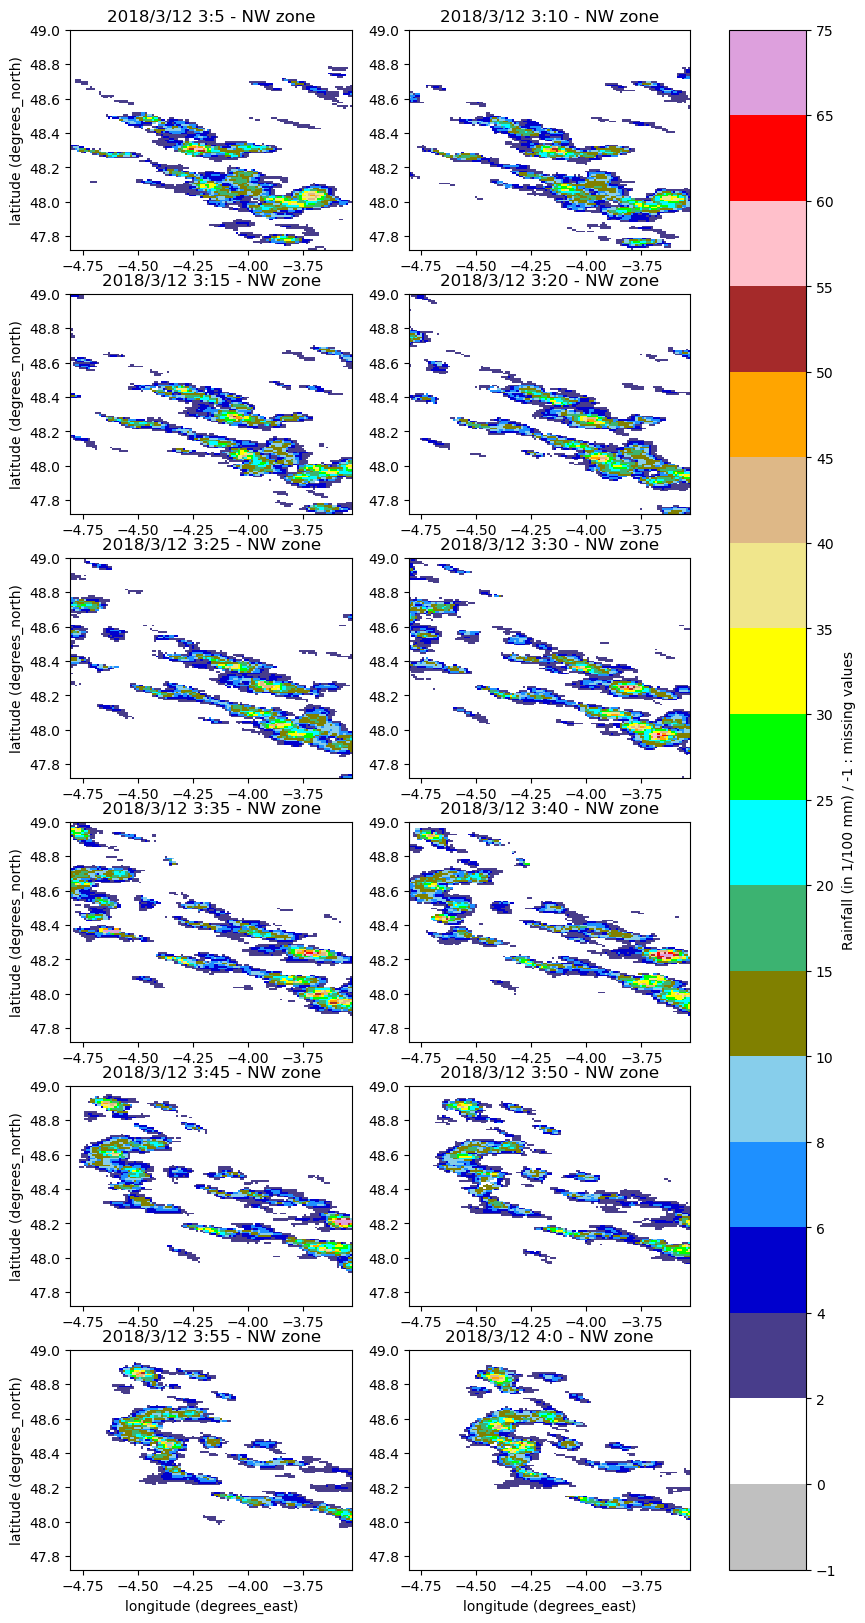

In [371]:
from data.constants import *
import numpy as np
from os.path import dirname, basename
from loader.utilities import split_date

coord = np.load(f'data/radar_coords_NW.npz',allow_pickle=True)
lon = coord['lons'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]
lat = coord['lats'][lat_extract_start:lat_extract_end, lon_extract_start:lon_extract_end]

train_date = 2017,3,1,12,0 # dans train_ds
val_date = 2018,3,12,3,5 # dans val_ds

plot_meteonet_rainmaps( val_ds, val_date, lon, lat, zone)

In [207]:
# three models
model_dom_rain = UNet( n_channels= 12, n_classes = 3, bilinear = True)
model_dom_rain.load_state_dict(torch.load('weights/model_dom_30m_rain.pt'))

model_dom = UNet( n_channels= 12*3, n_classes = 3, bilinear = True)
model_dom.load_state_dict(torch.load('weights/model_dom_30m_wind.pt'))

model_vinc = UNet( n_channels= 12*3, n_classes = 3, bilinear = True)
model_vinc.load_state_dict(torch.load('weights/model_vinc_30m_wind.pt'))


<All keys matched successfully>

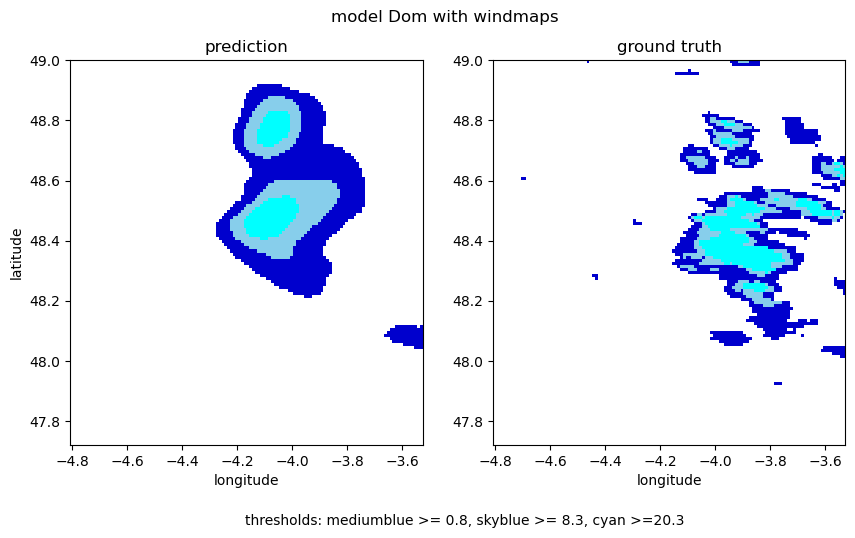

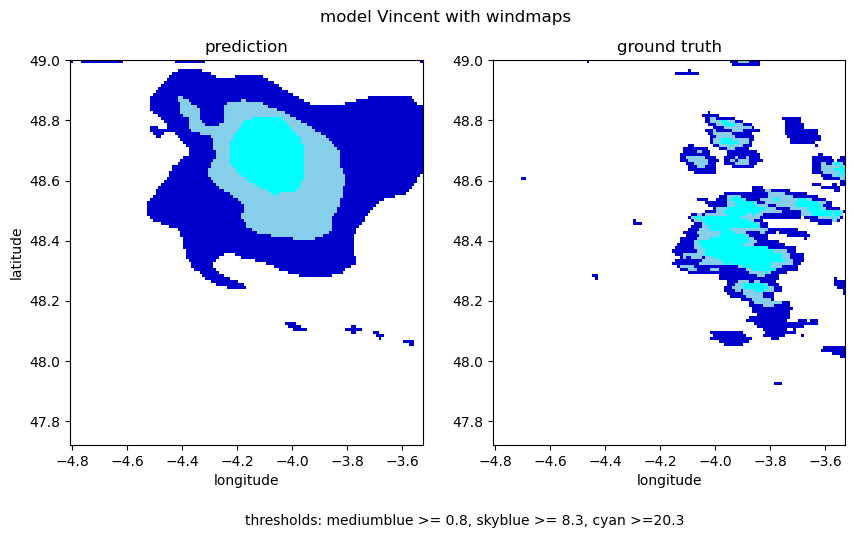

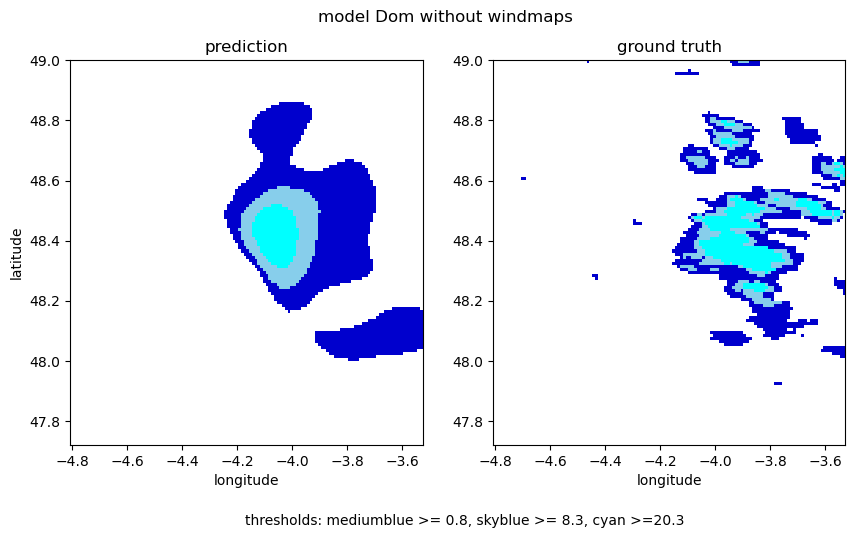

In [400]:
plot_inference( val_ds, date, model_dom, lon, lat, zone, 'model Dom with windmaps')
plot_inference( val_ds, date, model_vinc, lon, lat, zone, 'model Vincent with windmaps')
plot_inference( rain_val_ds, date, model_dom_rain, lon, lat, zone, 'model Dom without windmaps')


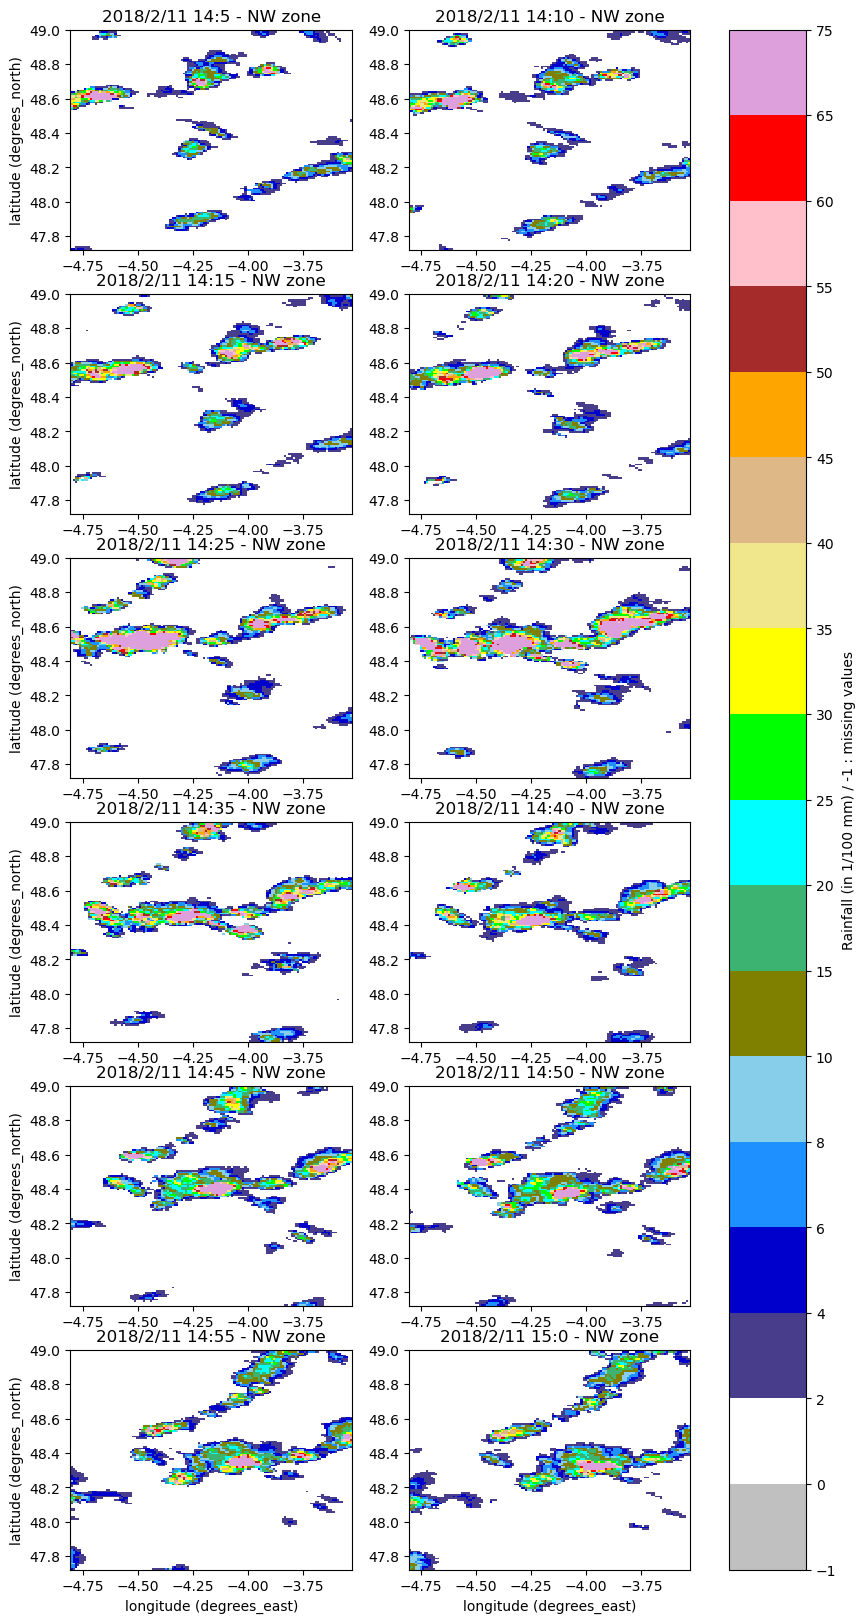

In [387]:
test_date = 2018, 2, 11, 14, 5
plot_meteonet_rainmaps( test_ds, test_date, lon, lat, zone)

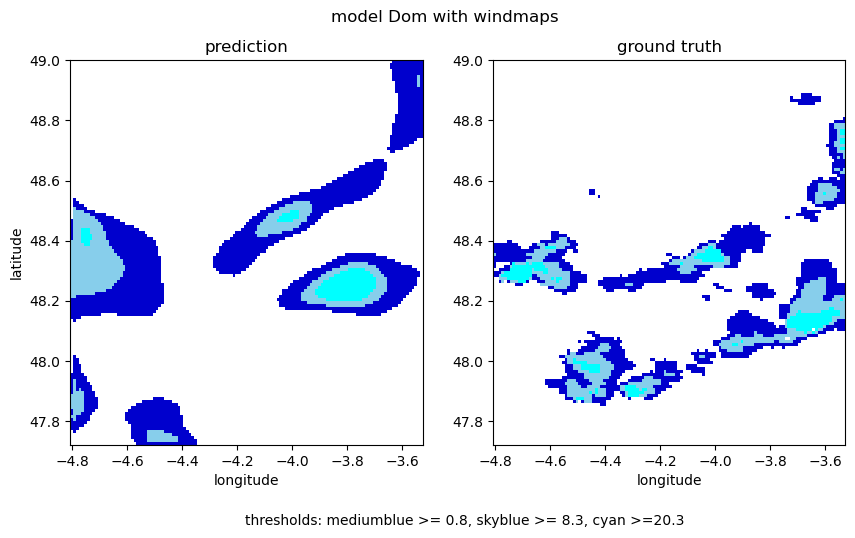

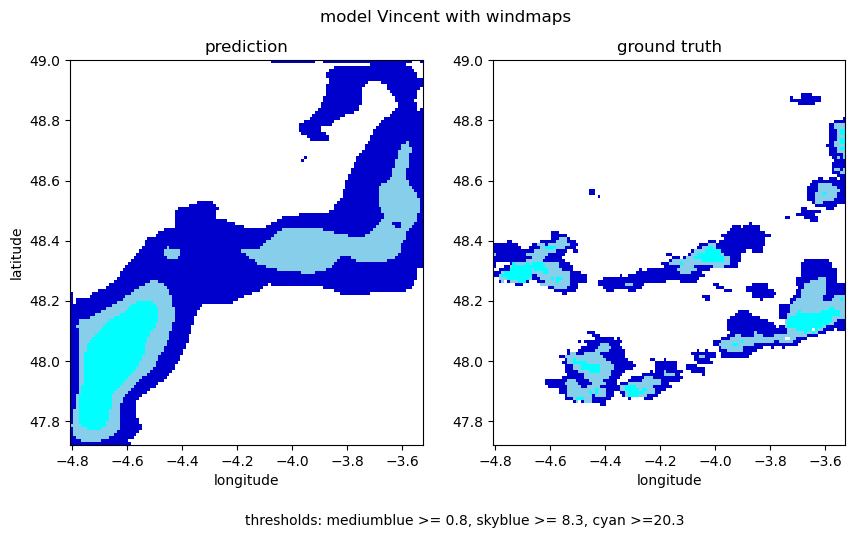

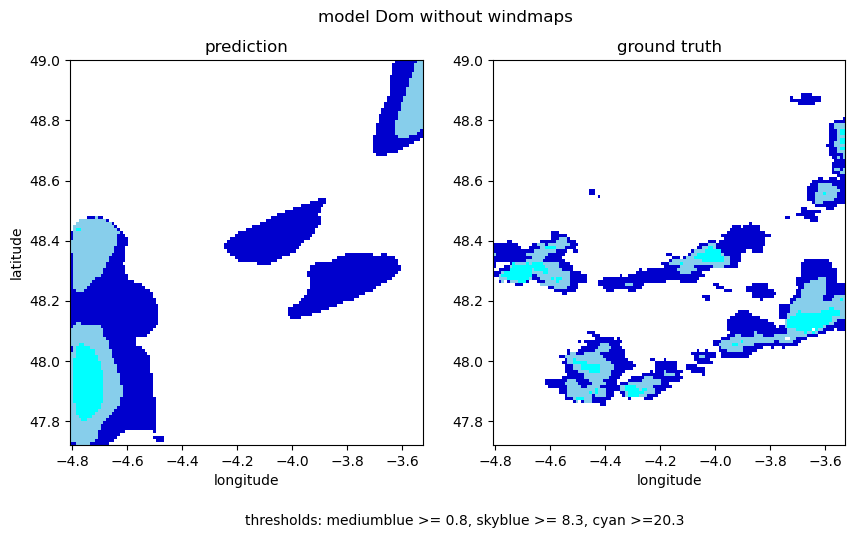

In [401]:
plot_inference( test_ds, test_date, model_dom, lon, lat, zone, 'model Dom with windmaps')
plot_inference( test_ds, test_date, model_vinc, lon, lat, zone, 'model Vincent with windmaps')
plot_inference( rain_test_ds, test_date, model_dom_rain, lon, lat, zone, 'model Dom without windmaps')
